<a href="https://colab.research.google.com/github/kushalt09/colab/blob/main/Sign_Forgery_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data preprocessing

In [ ]:
! pip install -q kaggle
from google.colab import files
# files.upload()

In [ ]:
! mkdir ~/.kaggle/

In [ ]:
! cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
! kaggle datasets download -d robinreni/signature-verification-dataset

Dataset URL: https://www.kaggle.com/datasets/robinreni/signature-verification-dataset
License(s): CC0-1.0
100% 601M/601M [00:31<00:00, 24.1MB/s]
100% 601M/601M [00:31<00:00, 19.7MB/s]


In [ ]:
from zipfile import ZipFile
file_name = "signature-verification-dataset.zip"
with ZipFile(file_name, 'r') as zip:
    print('Extracting all the files now...')
    zip.extractall()
    print('Done!')

Extracting all the files now...
Done!


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import cv2
from tensorflow.keras.layers import Input, Lambda, MaxPooling2D, BatchNormalization, Dense, Flatten, Activation,Convolution2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
import os
from tensorflow.keras.losses import Loss
from keras.preprocessing import image

In [ ]:
def read_data(dir, data):
    images1 = []
    images2 = []
    labels = []
    for j in range(0, len(data)):
        path = os.path.join(dir,data.iat[j, 0])
        img1 = cv2.imread(path)
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
        img1 = cv2.resize(img1, (100, 100))
        images1.append([img1])
        path = os.path.join(dir, data.iat[j, 1])
        img2 = cv2.imread(path)
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
        img2 = cv2.resize(img2, (100, 100))
        images2.append([img2])
        labels.append(np.array(data.iat[j, 2]))
    # Normalize to lesser value
    images1 = np.array(images1).astype(np.float32) / 255.0
    images2 = np.array(images2).astype(np.float32) / 255.0
    labels = np.array(labels).astype(np.float32)
    return images1, images2, labels

In [ ]:
train_dir = '/content/sign_data/train'
train_csv = '/content/sign_data/train_data.csv'
df_train = pd.read_csv(train_csv, header=None)
train_images1, train_images2, train_labels = read_data(dir=train_dir, data=df_train)
train_labels = to_categorical(train_labels)

In [ ]:
size = 100
train_images1 = train_images1.reshape(-1, size, size, 1)
train_images2 = train_images2.reshape(-1, size, size, 1)

In [ ]:
print(df_train.iloc[0, :])
img_org = df_train.iloc[0, 0]
img_frg = df_train.iloc[0, 1]

0             068/09_068.png
1    068_forg/03_0113068.PNG
2                          1
Name: 0, dtype: object


/content/sign_data/train/068/09_068.png


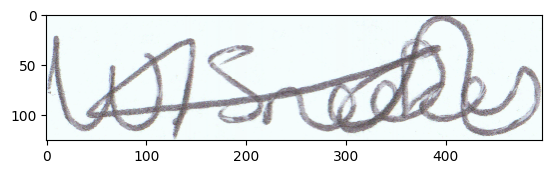

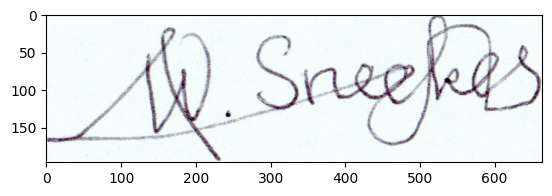

In [ ]:
img_original = plt.imread('/content/sign_data/train/'+img_org)
img_forged = plt.imread('/content/sign_data/train/'+img_frg)

print('/content/sign_data/train/'+img_org)

plt.subplots(1, 1, sharex=True, sharey=True)
plt.imshow(img_original)

plt.subplots(1, 1, sharex=True, sharey=True)
plt.imshow(img_forged)

# Simple Siamese Network

In [ ]:
def initialize_base_network(input_shape):
    clf = Sequential()
    clf.add(Convolution2D(64, (3,3),input_shape=input_shape))
    clf.add(Activation('relu'))
    clf.add(MaxPooling2D(pool_size=(2, 2)))
    clf.add(Convolution2D(32, (3,3)))
    clf.add(Activation('relu'))
    clf.add(MaxPooling2D(pool_size=(2, 2)))
    clf.add(Flatten())
    clf.add(Dense(128, activation='relu'))
    clf.add(Dense(64, activation='relu'))
    return clf
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [ ]:
input_dim = (100, 100, 1)
base_network = initialize_base_network(input_dim)
img_a = Input(shape=input_dim)
img_b = Input(shape=input_dim)
vec_a = base_network(img_a)
vec_b = base_network(img_b)
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([vec_a, vec_b])
prediction = Dense(2, activation='softmax')(distance)
model = Model([img_a, img_b], prediction)
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 100, 100, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 100, 100, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 64)             │      2,194,272 │ input_layer_1[0][0],   │
│                           │                        │                │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 1)              │              0 │ sequential[0][0],      │
│                           │                        │                │ sequential[1][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 2)              │              4 │ lambda[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,194,276 (8.37 MB)

 Trainable params: 2,194,276 (8.37 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=0.00008)
model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])
history = model.fit([train_images1,train_images2],train_labels,validation_split=.30,batch_size=32,epochs=1)



508/508 ━━━━━━━━━━━━━━━━━━━━ 647s 1s/step - accuracy: 0.5675 - loss: 0.6860 - val_accuracy: 0.4984 - val_loss: 0.7146


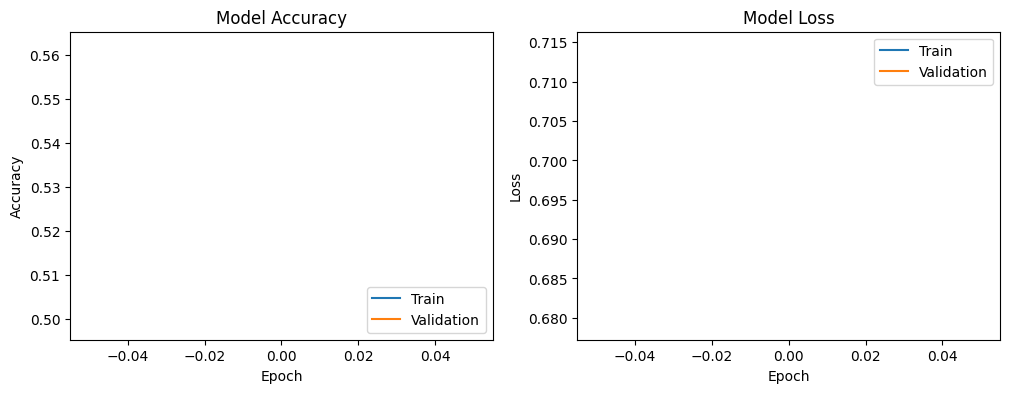

In [ ]:
history_keys = history.history.keys()

plt.figure(figsize=(12, 4))

# Plot the accuracy curves
if 'accuracy' in history_keys and 'val_accuracy' in history_keys:
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='lower right')

# Plot the loss curves
if 'loss' in history_keys and 'val_loss' in history_keys:
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

180/180 ━━━━━━━━━━━━━━━━━━━━ 53s 292ms/step - accuracy: 0.4676 - loss: 0.6981
Test Loss: 0.7022828459739685
Test Accuracy: 0.48225468397140503
180/180 ━━━━━━━━━━━━━━━━━━━━ 52s 290ms/step
Confusion Matrix:
[[2772    0]
 [2976    0]]


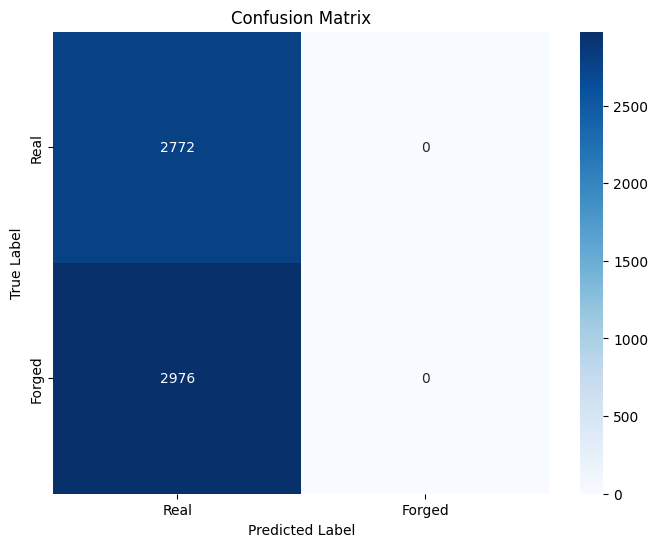

In [ ]:
# Load test data
test_dir = '/content/sign_data/test'
test_csv = '/content/sign_data/test_data.csv'
df_test = pd.read_csv(test_csv, header=None)
test_images1, test_images2, test_labels = read_data(dir=test_dir, data=df_test)
test_labels = to_categorical(test_labels)

# Preprocess test data
test_images1 = test_images1.reshape(-1, size, size, 1)
test_images2 = test_images2.reshape(-1, size, size, 1)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate([test_images1, test_images2], test_labels)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Predictions on test data
predictions = model.predict([test_images1, test_images2])
predicted_labels = np.argmax(predictions, axis=1)

# Create confusion matrix
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(np.argmax(test_labels, axis=1), predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

# Visualize confusion matrix
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Real', 'Forged'], yticklabels=['Real', 'Forged'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import tensorflow as tf
model.save('my_model.keras')
model.save('my_model.h5')
# Save model in TensorFlow SavedModel format
tf.saved_model.save(model, 'saved_model/my_model')  # Correct function to use for SavedModel format
from shutil import make_archive
make_archive('saved_model', 'zip', 'saved_model')

'/content/saved_model.zip'

In [ ]:
loaded_model = tf.keras.models.load_model('my_model.h5',
                                          custom_objects={
                                              'euclidean_distance': euclidean_distance,
                                              'eucl_dist_output_shape': eucl_dist_output_shape
                                          })
loaded_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step
[[0.58770895 0.41229102]]


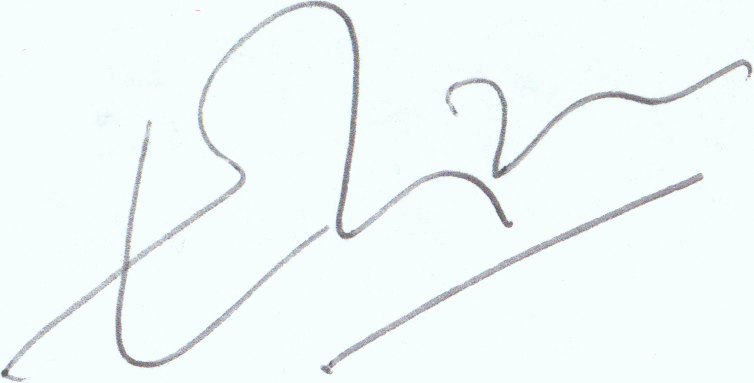

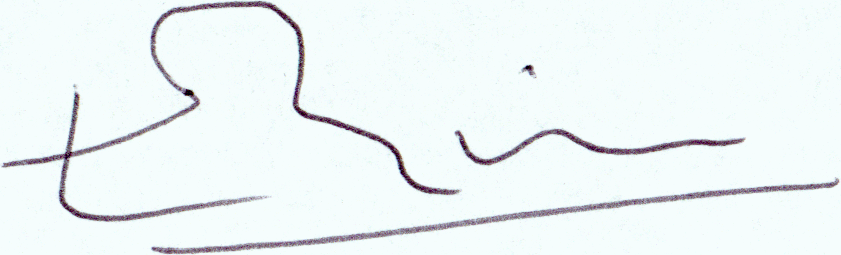

In [ ]:
img_original = '/content/original.png'
img_forged = '/content/forged.png'

x = image.load_img(img_original, target_size=(100, 100))
x = image.img_to_array(x)
x = tf.image.rgb_to_grayscale(x)
x = np.expand_dims(x, axis=0)
x = x/255.0

y = image.load_img(img_forged, target_size=(100, 100))
y = image.img_to_array(y)
y = tf.image.rgb_to_grayscale(y)
y = np.expand_dims(y, axis=0)
y = y/255.0
y_pred = loaded_model.predict([x,y])
# confidence percentage [0.98,0.01999]
print(y_pred)
# index of the higher value
y_pred = np.argmax(y_pred)


# show input images
from IPython.display import Image,display
display(Image(img_original))
display(Image(img_forged))

In [ ]:
if y_pred==1:
  print('Forged')
else:
  print('Real')

Real
